In [292]:
%matplotlib inline
import seaborn as sns

#import libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import re
import enchant

#preprocessing
from sklearn.preprocessing import StandardScaler

#nltk libraries
import nltk

#stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# import model and fit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [293]:
#read in price dataframe and sentiment dataframe

df_sentiment = pd.read_csv('df_sentiment2.csv')
df_bitcoinprice = pd.read_csv('bitcoinprice.csv')

In [294]:
df_sentiment.head()

df_sentiment.rename(columns={'year_month_day':'time'}, 
                 inplace=True)

In [295]:
df_bitcoinprice.head()

,Unnamed: 0,time,close,high,low,open,volumefrom,volumeto
0,0,2019-08-15,10308.51,10451.61,9497.12,10031.89,84438.15,8.429791e+08
1,1,2019-08-14,10031.89,10873.44,9924.58,10872.00,70125.86,7.282475e+08
2,2,2019-08-13,10872.00,11439.48,10765.30,11387.41,43742.98,4.832401e+08
3,3,2019-08-12,11387.41,11554.74,11240.38,11549.06,20181.72,2.299081e+08
4,4,2019-08-11,11549.06,11584.35,11119.32,11293.59,25734.51,2.928147e+08


In [296]:
df_bitcoinprice.dtypes

Unnamed: 0      int64
time           object
close         float64
high          float64
low           float64
open          float64
volumefrom    float64
volumeto      float64
dtype: object

In [297]:
#join dataframe on time
df_outer = pd.merge(df_bitcoinprice, df_sentiment, on='time', how='outer')


In [298]:
df_outer.head()

,Unnamed: 0_x,time,close,high,low,open,volumefrom,volumeto,Unnamed: 0_y,year_month,date_time,date_time_week,published_on,tags,body,title,text,compound_score_vader,compound_score_tb,sentiment
0,0,2019-08-15,10308.51,10451.61,9497.12,10031.89,84438.15,842979140.9,0.0,2019-08,2019-08-15 22:00:47,2019-32,1.565906e+09,Bitcoin|Opinion|argentina|bitcoin|safe haven,Bitcoin has been trading for a premium of betw...,Argentine Bitcoin Premium Shows Relativity of ...,argentine bitcoin premium shows relativity of ...,-0.1280,0.132000,0.002000
1,0,2019-08-15,10308.51,10451.61,9497.12,10031.89,84438.15,842979140.9,1.0,2019-08,2019-08-15 22:00:21,2019-32,1.565906e+09,Bitcoin|Bitcoin Price|News|News teaser|bitcoin...,Bitcoin’s market valuation has already made so...,Brandt’s Momentum Indicator Highlights Potenti...,brandts momentum indicator highlights potentia...,0.4280,0.121429,0.274714
2,0,2019-08-15,10308.51,10451.61,9497.12,10031.89,84438.15,842979140.9,2.0,2019-08,2019-08-15 21:55:41,2019-32,1.565906e+09,Cryptocurrencies|bitcoin|cryptocurrency|Market...,Paxful’s peer-to-peer Bitcoin exchange got a b...,Bitcoin peer-to-peer exchange Paxful sees 70 p...,bitcoin peertopeer exchange paxful sees perce...,0.4019,0.083333,0.242617
3,0,2019-08-15,10308.51,10451.61,9497.12,10031.89,84438.15,842979140.9,3.0,2019-08,2019-08-15 21:21:14,2019-32,1.565904e+09,News|Bitcoin|Government|Politics|USA,"Move over, John McAfee, there&#8217;s a new cr...",Crypto Candidate Andrew Yang Talks Up Bitcoin ...,crypto candidate andrew yang talks up bitcoin ...,0.2062,0.197727,0.201964
4,0,2019-08-15,10308.51,10451.61,9497.12,10031.89,84438.15,842979140.9,4.0,2019-08,2019-08-15 21:19:06,2019-32,1.565904e+09,Analysis|EOS|Ethereum|Tron,TRON announced the latest release of its side ...,Is TRON’s Sun Network a marketing gimmick? Com...,is trons sun network a marketing gimmick compa...,0.8750,0.286616,0.580808


In [299]:
#need to clean this massive dataframe
#drop columns and indexes

df_outer.columns

Index(['Unnamed: 0_x', 'time', 'close', 'high', 'low', 'open', 'volumefrom',
       'volumeto', 'Unnamed: 0_y', 'year_month', 'date_time', 'date_time_week',
       'published_on', 'tags', 'body', 'title', 'text', 'compound_score_vader',
       'compound_score_tb', 'sentiment'],
      dtype='object')

In [300]:
df_outer.dtypes

Unnamed: 0_x              int64
time                     object
close                   float64
high                    float64
low                     float64
open                    float64
volumefrom              float64
volumeto                float64
Unnamed: 0_y            float64
year_month               object
date_time                object
date_time_week           object
published_on            float64
tags                     object
body                     object
title                    object
text                     object
compound_score_vader    float64
compound_score_tb       float64
sentiment               float64
dtype: object

In [301]:
#converting datetimes and populating datetimes
df_outer['time'] = pd.to_datetime(df_outer['time'])
df_outer['date_time_week'] = df_outer.time.dt.strftime("%Y-%W")
df_outer['year_month'] = df_outer.time.dt.strftime("%Y-%m")
df_outer['time'] = df_outer['time'].astype(str)


In [302]:
#Create Daily DF

dropcol = ['Unnamed: 0_x', 'high', 'low', 'open', 'volumefrom',
        'Unnamed: 0_y',
       'published_on', 'body', 'title', 'text','tags', 'compound_score_vader',
       'compound_score_tb']
df_price_sentiment = df_outer.drop(dropcol, axis = 1)
df_price_sentiment.head()

,time,close,volumeto,year_month,date_time,date_time_week,sentiment
0,2019-08-15,10308.51,842979140.9,2019-08,2019-08-15 22:00:47,2019-32,0.002000
1,2019-08-15,10308.51,842979140.9,2019-08,2019-08-15 22:00:21,2019-32,0.274714
2,2019-08-15,10308.51,842979140.9,2019-08,2019-08-15 21:55:41,2019-32,0.242617
3,2019-08-15,10308.51,842979140.9,2019-08,2019-08-15 21:21:14,2019-32,0.201964
4,2019-08-15,10308.51,842979140.9,2019-08,2019-08-15 21:19:06,2019-32,0.580808


In [303]:
#df_price_sentiment.to_csv('price_sentiment.csv') save to csv

In [304]:
#find nans in dataframe and fill them
df_price_sentiment.isnull().sum(axis=0)
#fill sentiment nans with 0
#df_price_sentiment.fillna(df_price_sentiment.sentiment.mean(), inplace = True)
df_price_sentiment.fillna(0, inplace = True)

In [305]:
#groupby time and aggregate into average sentiment
df_price_sentiment = df_price_sentiment.groupby(['time','date_time_week','year_month','close','volumeto'])['sentiment'].mean().reset_index()

In [306]:
df_price_sentiment = df_price_sentiment.sort_values(by = 'time')

In [307]:
#getting 7 day rolling sentiment
df_price_sentiment['sentiment_7dayrolling'] = df_price_sentiment['sentiment'].rolling(7).mean()


In [308]:
#calculate percentage change
df_price_sentiment['dailychange'] = (df_price_sentiment['close'] - df_price_sentiment['close'].shift(1))/df_price_sentiment['close'].shift(1)
df_price_sentiment['dailychange_sent_raw'] = (df_price_sentiment['sentiment'] - df_price_sentiment['sentiment'].shift(1))
df_price_sentiment['dailychange_sent_7day'] = (df_price_sentiment['sentiment_7dayrolling'] - df_price_sentiment['sentiment_7dayrolling'].shift(1))

In [309]:
df_price_sentiment.head(10)

,time,date_time_week,year_month,close,volumeto,sentiment,sentiment_7dayrolling,dailychange,dailychange_sent_raw,dailychange_sent_7day
0,2017-09-02,2017-35,2017-09,4573.80,7.477138e+08,0.000000,NaN,NaN,NaN,NaN
1,2017-09-03,2017-35,2017-09,4612.92,4.701358e+08,0.000000,NaN,0.008553,0.000000,NaN
2,2017-09-04,2017-36,2017-09,4267.45,7.372161e+08,0.000000,NaN,-0.074892,0.000000,NaN
3,2017-09-05,2017-36,2017-09,4409.08,6.738468e+08,0.000000,NaN,0.033188,0.000000,NaN
4,2017-09-06,2017-36,2017-09,4618.71,5.047172e+08,0.000000,NaN,0.047545,0.000000,NaN
5,2017-09-07,2017-36,2017-09,4635.60,3.249399e+08,0.000000,NaN,0.003657,0.000000,NaN
6,2017-09-08,2017-36,2017-09,4326.45,7.868199e+08,0.136600,0.019514,-0.066690,0.136600,NaN
7,2017-09-09,2017-36,2017-09,4335.13,3.321953e+08,0.000000,0.019514,0.002006,-0.136600,0.000000
8,2017-09-10,2017-36,2017-09,4245.89,4.512444e+08,0.000000,0.019514,-0.020585,0.000000,0.000000
9,2017-09-11,2017-37,2017-09,4217.90,3.752541e+08,-0.188375,-0.007396,-0.006592,-0.188375,-0.026911


In [310]:
#df_price_sentiment.to_csv('btc_price_sentiment_tableau.csv') #use tableau to chart this

In [311]:
df_sentiment_final = df_price_sentiment.dropna(subset = ['sentiment_7dayrolling'], axis = 0)

df_sentiment_final.sort_values(by = 'time', inplace = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


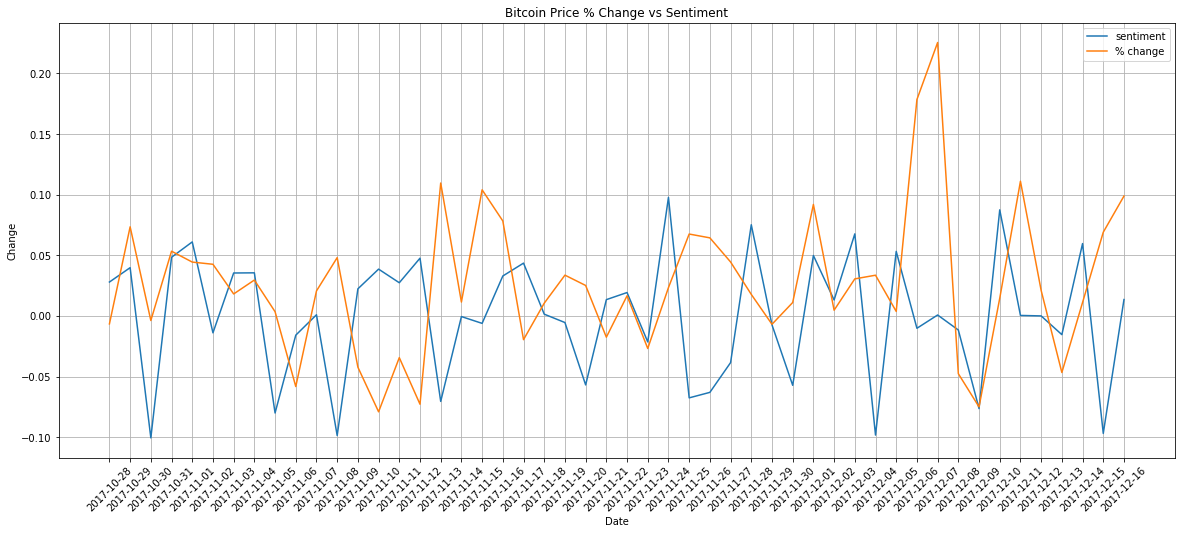

In [320]:
#Daily Chartdf_sentiment_final

start_index = 50 #index of row where you want your start date to be #50 and 100 good example
end_index = 100 #index of row where you want your start date to be #712 is the latest day

plt.figure(figsize=(20,8))
sns.lineplot(x=df_sentiment_final['time'][start_index:end_index],y=df_sentiment_final['dailychange_sent_raw'][start_index:end_index])
sns.lineplot(x=df_sentiment_final['time'][start_index:end_index],y=df_sentiment_final['dailychange'][start_index:end_index])

plt.xlabel('Date')
plt.ylabel('Change')
plt.title('Bitcoin Price % Change vs Sentiment')
plt.legend(['sentiment','% change'])
plt.xticks(df_sentiment_final['time'][start_index:end_index],rotation=45)
plt.grid()

In [313]:
#create weekly close and sentiment chart
df_price_sentiment.sort_values(by = 'time', inplace = True)
df_weekly = df_price_sentiment.groupby(['date_time_week'], as_index = False)[['sentiment','close']].last()#.close.last()
df_weekly['weeklychange'] = (df_weekly['close'] - df_weekly['close'].shift(1))/df_weekly['close'].shift(1)
df_weekly['weeklychange_sent_raw'] = (df_weekly['sentiment'] - df_weekly['sentiment'].shift(1))
df_weekly

,date_time_week,sentiment,close,weeklychange,weeklychange_sent_raw
0,2017-35,0.000000,4612.92,NaN,NaN
1,2017-36,0.000000,4245.89,-0.079566,0.000000
2,2017-37,0.000000,3689.61,-0.131016,0.000000
3,2017-38,0.186902,3667.52,-0.005987,0.186902
4,2017-39,0.158267,4403.09,0.200563,-0.028635
5,2017-40,0.234104,4611.70,0.047378,0.075837
6,2017-41,0.160497,5688.14,0.233415,-0.073607
7,2017-42,0.270404,5982.86,0.051813,0.109907
8,2017-43,0.231227,6147.52,0.027522,-0.039177
9,2017-44,0.217061,7389.55,0.202038,-0.014166


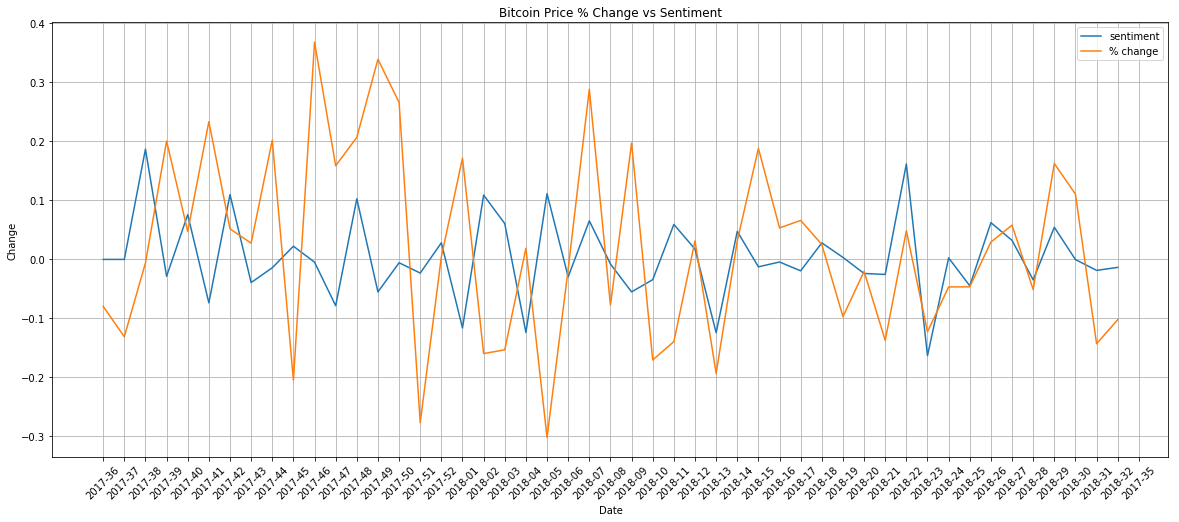

In [314]:
#Daily Chartdf_sentiment_final

start_index = 0 #index of row where you want your start date to be #50 and 100 good example
end_index = 50 #index of row where you want your start date to be

plt.figure(figsize=(20,8))
sns.lineplot(x=df_weekly['date_time_week'][start_index:end_index],y=df_weekly['weeklychange_sent_raw'][start_index:end_index])
sns.lineplot(x=df_weekly['date_time_week'][start_index:end_index],y=df_weekly['weeklychange'][start_index:end_index])

plt.xlabel('Date')
plt.ylabel('Change')
plt.title('Bitcoin Price % Change vs Sentiment')
plt.legend(['sentiment','% change'])
plt.xticks(df_weekly['date_time_week'][start_index:end_index],rotation=45)
plt.grid()


In [315]:
#X, y = df_sentiment_final[['sentiment','volumeto','sentiment_7dayrolling']], df_sentiment_final['close']
X, y = df_sentiment_final[['volumeto','sentiment_7dayrolling']], df_sentiment_final['close']

In [316]:
#creating a base linear regression model
lm = LinearRegression()
lm.fit(X, y)

print(f'Linear Regression val R^2: {lm.score(X, y)}') 

Linear Regression val R^2: 0.5201266523641934


In [317]:
#create monthly close and sentiment chart
df_price_sentiment.sort_values(by = 'time', inplace = True)
df_monthly = df_price_sentiment.groupby(['year_month'], as_index = False)[['sentiment','close']].last()#.close.last()
df_monthly['monthdf_monthlylychange'] = (df_monthly['close'] - df_monthly['close'].shift(1))/df_monthly['close'].shift(1)
df_monthly['weeklychange_sent_raw'] = (df_monthly['sentiment'] - df_monthly['sentiment'].shift(1))
df_monthly

,year_month,sentiment,close,monthdf_monthlylychange,weeklychange_sent_raw
0,2017-09,0.230852,4360.62,NaN,NaN
1,2017-10,0.179058,6451.24,0.479432,-0.051793
2,2017-11,0.128355,9946.76,0.541837,-0.050704
3,2017-12,0.203336,13850.40,0.392453,0.074981
4,2018-01,0.163518,10226.86,-0.261620,-0.039819
5,2018-02,0.128230,10334.44,0.010519,-0.035288
6,2018-03,0.075057,6943.77,-0.328094,-0.053173
7,2018-04,0.165320,9248.45,0.331906,0.090263
8,2018-05,0.172161,7502.15,-0.188821,0.006840
9,2018-06,0.145441,6385.38,-0.148860,-0.026719


In [318]:
df_monthly.to_csv('btc_monthly_sentiment_close.csv')

In [319]:
df_weekly.to_csv('btc_weekly_sentiment_close.csv')